In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
from xgboost import plot_importance

In [2]:
df = pd.read_csv('data/preprocessed_data.csv')
df = df[df['Label'] == 1];
df.drop(columns=['Label'], inplace=True)
df.head()

,VMakeModel,VMake,VYear,Distance,Months,AdjustedPrice
0,TOYOTA RAV4,TOYOTA,2016.0,"320,000 km",192 months,370.0
1,MAZDA 3,MAZDA,2015.0,"160,000 km",192 months,454.0
2,TOYOTA HIACE,TOYOTA,2010.0,"260,000 km",156 months,367.0
3,SUBARU OUTBACK,SUBARU,2018.0,"50,000 km",24 months,568.0
4,TOYOTA HIACE,TOYOTA,2015.0,"160,000 km",96 months,939.0


In [3]:
X = df.drop(columns=["AdjustedPrice"])  
y = df["AdjustedPrice"]       

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [5]:
# Identify feature types
cat_features = X_train.select_dtypes(include=["object", "category"]).columns


In [6]:
for col in X_train.select_dtypes(include='object').columns:
    X_train[col] = X_train[col].astype('category')


for col in X_test.select_dtypes(include='object').columns:
    X_test[col] = X_test[col].astype('category')

In [7]:

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    nonzero_mask = y_true != 0
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

In [ ]:

model = XGBRegressor(
        random_state=42,
        tree_method="hist",
        enable_categorical=True
    )

param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [6, 7, 8, 9],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

# Define stratified k-fold
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Setup random search
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=cv,
    verbose=1,
    n_jobs=-1,
)

random_search.fit(X_train, y_train, 
                  verbose=False)



# Best model
best_model = random_search.best_estimator_

# Best params
print("Best Parameters:", random_search.best_params_)



Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'subsample': 0.6, 'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [9]:


from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred = best_model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape:.2f}%")


MAE: 195.07599040340753
RMSE: 279.31177783353263
MAPE: 39.46%


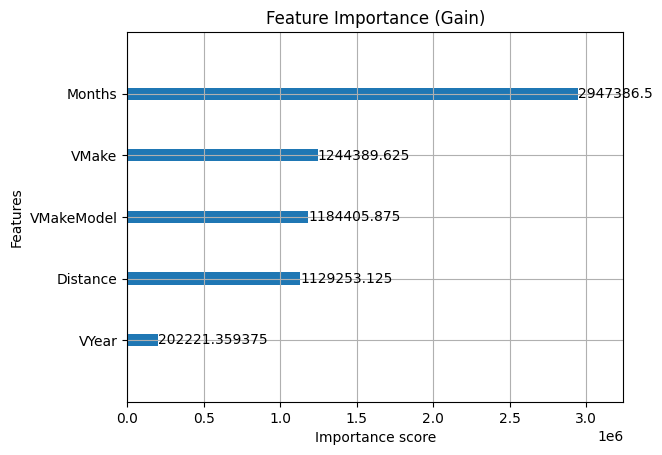

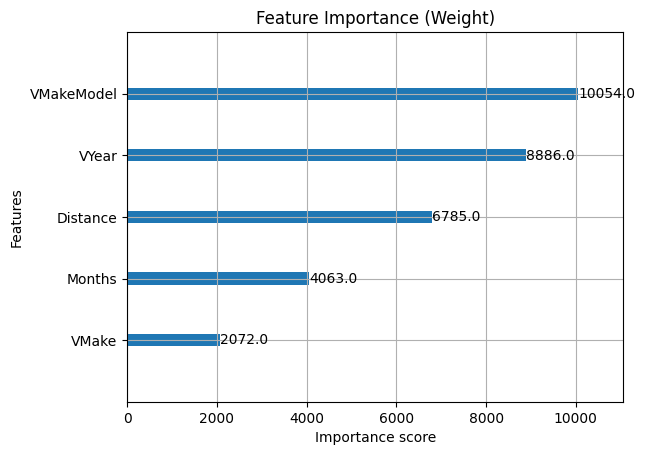

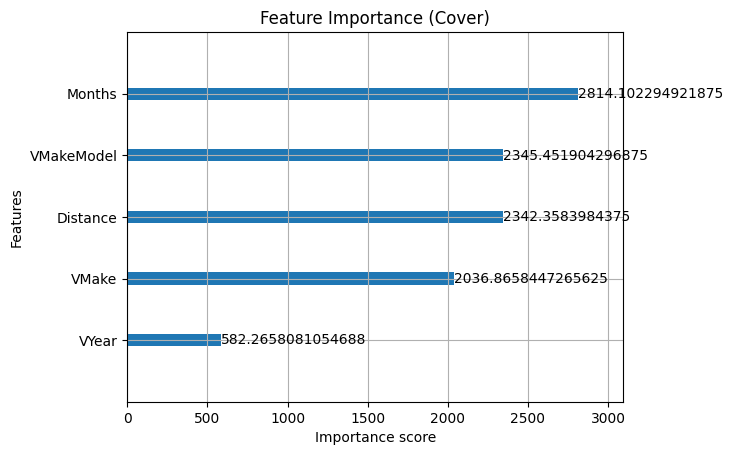

In [10]:
# Extract fitted XGBRegressor from pipeline
plot_importance(best_model, importance_type='gain', max_num_features=10)
plt.title('Feature Importance (Gain)')
plt.show()

# Weight importance plot
plot_importance(best_model, importance_type='weight', max_num_features=10)
plt.title('Feature Importance (Weight)')
plt.show()

# Cover importance plot
plot_importance(best_model, importance_type='cover', max_num_features=10)
plt.title('Feature Importance (Cover)')
plt.show()